In [8]:
from ase.io import read
from crystals import Crystal
from skued import powdersim
import os
from skfda import FDataGrid
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import (train_test_split, GridSearchCV)
from sklearn.model_selection import StratifiedShuffleSplit
from skfda.ml.classification import KNeighborsClassifier
import skfda.preprocessing.smoothing.kernel_smoothers as ks
import skfda.preprocessing.smoothing.validation as val
from sklearn.model_selection import cross_val_score

In [9]:
def load_datagrid_sim(folder, arr, x):
    '''
    Load cif files from folder into ase crystal objects, simulate crystal
    diffraction and represent data in timeseries
    Args:
        folder (string): Where we load the data from.
        arr (list): List of cif filenames in folder.
        x (nparray): representation of 1/angström for powder simulation.

    Returns:
        fd (datagrid): representation of intensity values and 1/angström
        values in datagrid object.

    '''
    filename_arr = []
    crys_arr = []
    for file in arr:
        filename = os.sep.join([folder, file])
        filename_arr.append(file)
        crys = read(filename)
        crys = Crystal.from_ase(crys)
        
        diff = powdersim(crys, x, fwhm_l=50)
        diff_norm = diff / diff.max()
        crys_arr.append(diff_norm)
        
    crys_arr = np.array(crys_arr)
    fd = FDataGrid(crys_arr, x,
                   dataset_name='Diffraction Curves',
                   argument_names=[r'$q (1/\AA)$'],
                   coordinate_names=['Diffracted intensity (A.u.)'])
    print(fd)
    
    return fd

In [10]:
def smooth_datagrid(fd):
    '''
    Smoothes the values in the datagrid object

    Args:
        fd (datagrid): Includes data_matrix, x vector for contionous data
        representation.

    Returns:
        knn_fd (datagrid): datagrid values smoothed with an kN Kernel.

    '''
    # smooth the values with kNeighbors kernel
    param_values = np.linspace(start=2, stop=25, num=24)
    knn = val.SmoothingParameterSearch(ks.KNeighborsSmoother(), param_values)
    knn.fit(fd)
    knn_fd = knn.transform(fd)
    
    return knn_fd


In [11]:
folder = r"C:\Python\Projects\crystal-phase-prediction\crystal_data\CIFs"
arr = [f for f in os.listdir(folder) if not f.endswith('.ini')] # ignore hidden files in folder
x = np.linspace(1, 4, 1000)
# change for hfo2 and zro2
df_labels = pd.read_pickle(r'C:\Python\Projects\crystal-phase-prediction\data_labels\labels_all.pkl')
labels = df_labels['new_labels']

In [12]:
fd = load_datagrid_sim(folder, arr, x)

Data set:    [[[1.73345409e-04]
  [2.00338164e-04]
  [2.19382819e-04]
  ...
  [9.33040238e-02]
  [6.50832603e-02]
  [4.30676566e-02]]

 [[2.31974264e-06]
  [2.32488304e-06]
  [2.33930170e-06]
  ...
  [2.71384179e-02]
  [1.64262500e-02]
  [9.51887973e-03]]

 [[1.39205404e-06]
  [1.39209243e-06]
  [1.39218540e-06]
  ...
  [5.55219838e-03]
  [4.20570261e-03]
  [3.02872304e-03]]

 ...

 [[4.06259906e-06]
  [4.06264693e-06]
  [4.06269469e-06]
  ...
  [1.39836140e-02]
  [1.10129638e-02]
  [8.50937513e-03]]

 [[1.12794755e-06]
  [1.12795993e-06]
  [1.12797228e-06]
  ...
  [1.32386925e-04]
  [8.11638015e-05]
  [5.07909364e-05]]

 [[1.12806761e-06]
  [1.12807999e-06]
  [1.12809234e-06]
  ...
  [1.32502978e-04]
  [8.13024236e-05]
  [5.09319246e-05]]]
sample_points:    [array([1.        , 1.003003  , 1.00600601, 1.00900901, 1.01201201,
       1.01501502, 1.01801802, 1.02102102, 1.02402402, 1.02702703,
       1.03003003, 1.03303303, 1.03603604, 1.03903904, 1.04204204,
       1.04504505, 1.04804805

In [36]:
fd_arr = fd.to_numpy()
np.save(r'C:\Python\Projects\crystal-phase-prediction\pkl_files\func_data_all', fd_arr)

In [13]:
fd_knn = smooth_datagrid(fd)

In [24]:
labels = labels.values
labels = labels.astype(int)
labels

array([0, 2, 1, ..., 2, 4, 3])

In [26]:
# gridsearch for the best hyperparameter
X_train, X_test, y_train, y_test = train_test_split(fd_knn, labels, 
                                                    test_size= 0.30,
                                                    stratify= labels,
                                                    random_state=0)


param_grid = {'n_neighbors': np.arange(2, 30, 1)}
knn = KNeighborsClassifier(metric='euclidean', multivariate_metric=True)
ss = StratifiedShuffleSplit(n_splits=5, test_size=.25, random_state=0)
gscv = GridSearchCV(knn, param_grid, cv=ss)
gscv.fit(fd_knn, labels)

print("Best params:", gscv.best_params_)
print("Best score:", gscv.best_score_)

Best params: {'n_neighbors': 7}
Best score: 0.9163383545770568


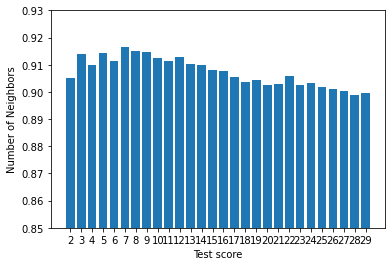

In [27]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.bar(param_grid['n_neighbors'], gscv.cv_results_['mean_test_score'])
ax.set_xticks(param_grid['n_neighbors'])
ax.set_ylabel("Number of Neighbors")
ax.set_xlabel("Test score")
ax.set_ylim((0.85, 0.93))
plt.show()

In [30]:
knn = KNeighborsClassifier(n_neighbors=7, metric='l2', 
                           multivariate_metric=True)

scores = cross_val_score(knn, fd_knn, labels, cv=10)
print(scores)
print('Accuracy: %0.2f (+- %0.2f)' %(scores.mean(), scores.std() * 2))

[0.89855072 0.84637681 0.87246377 0.87246377 0.95072464 0.86956522
 0.89275362 0.91304348 0.93043478 0.90724638]
Accuracy: 0.90 (+- 0.06)
